In [1]:
import csv

## Function for Mean
def getMean(sample):
    sampleSize = len(sample)
    totalSumIncome = 0
    for row in sample:
        totalSumIncome = row + totalSumIncome
    mean = totalSumIncome / sampleSize
    return mean

## Function target sample variance
def getSampleVariance(sample):
    mean = getMean(sample)
    sumOfSquares = 0
    sampleSize = len(sample)
    for row in sample:
        deviationScore = row - mean
        sumOfSquares = deviationScore**2 + sumOfSquares
    variance = sumOfSquares / (sampleSize-1)
    return variance

## Function target sample Standard Deviation
def getSampleSD(sample):
    mean = getMean(sample)
    sumOfSquares = 0
    sampleSize = len(sample)
    for row in sample:
        deviationScore = row - mean
        sumOfSquares = deviationScore**2 + sumOfSquares
    
    variance = sumOfSquares / (sampleSize-1)
    sampleSD = variance**0.5
    return sampleSD

## Sample Standard Error
def getSampleStandardError(sample):
    sampleSize = len(sample)
    sampleSD = getSampleSD(sample)
    # standard error of the mean for the population
    SSE = sampleSD / sampleSize**0.5
    return SSE

In [2]:
## New
def getDeltaSD(sample1, sample2):
    sampleSize1 = len(sample1)
    sampleSize2 = len(sample2)
    variance1 = getSampleVariance(sample1)
    variance2 = getSampleVariance(sample2)
    
    deltaSD = (variance1/sampleSize1 + variance2/sampleSize2)**0.5
    return deltaSD

In [3]:
# pooled degrees of freedom. Also called the Welch-Scatterthwaite equation
def getPooledDF(sample1, sample2):
    sampleSize1 = len(sample1)
    sampleSize2 = len(sample2)
    variance1 = getSampleVariance(sample1)
    variance2 = getSampleVariance(sample2)
    
    numerator = (variance1/sampleSize1 + variance2/sampleSize2)**2
    d1 = ((variance1/sampleSize1)**2)/(sampleSize1 - 1)
    d2 = ((variance2/sampleSize2)**2)/(sampleSize2 - 1)
    denominator = d1 + d2
    df = numerator/denominator
    return df


In [4]:
## Welch's t-test for when two population variances are not assumed to be equal
def unequalVarianceTScore(sample1, sample2):
    mean1 = getMean(sample1)
    mean2 = getMean(sample2)
    deltaSD = getDeltaSD(sample1, sample2)
    t = (mean1 - mean2)/deltaSD
    return t

In [5]:
# Getting 
def getCriticalT(alpha, df, testType = 'two-tailed'):
    df = round(df)
    if df > 120:
        df = 120
    criticalT = 0
    
    if testType == 'two-tailed':
        with open('data/t_table.csv', newline='') as tFile:
            tData = csv.reader(tFile)
            for row in tData:
                if int(row[0]) == df:
                    if float(row[2]) >= (float(1-(alpha/2))):
                        criticalT = float(row[1])
                        break
   
    elif testType == 'one-tailed positive':
        with open('data/t_table.csv', newline='') as tFile:
            tData = csv.reader(tFile)
            for row in tData:
                if int(row[0]) == df:
                    if float(row[2]) >= (float(1-(alpha))):
                        criticalT = float(row[1])
                        break

    elif testType == 'one-tailed negative':
        with open('data/t_table.csv', newline='') as tFile:
            tData = csv.reader(tFile)
            for row in tData:
                if int(row[0]) == df:
                    if float(row[2]) >= (float(alpha)):
                        criticalT = float(row[1])
                        break
    return criticalT

In [6]:
## p score
def getPFromT(t, df):
    df = round(df)
    if df > 120:
        df = 120
    if t > 6:
        p = 1.0
    elif t < -6:
        p = 0.0
    elif t > -6 and t < 6:
        with open('data/t_table.csv', newline='') as tFile:
            tData = csv.reader(tFile)
            for row in tData:
                if float(row[1]) == round(float(t), 2):
                    p = float(row[2])
    return p

In [7]:
## Rather than something like "t-test" we are just calling this significance test
def significanceTest(sample1, sample2, alpha, testType='two-tailed'):

    ## different from previous videos
    df = getPooledDF(sample1, sample2)
    critT = getCriticalT(alpha, df, testType)
    t = unequalVarianceTScore(sample1, sample2)
    p = getPFromT(t, df)
    
    significant = False
    if testType == 'two-tailed':
        if t < -critT or t > critT:
            significant = True
    elif testType == 'one-tailed positive':
        if t > critT:
            significant = True
    elif testType == 'one-tailed negative':
        if t < -critT:
            significant = True
    
    return significant, t, critT, p

In [8]:
## Same 
def getCI(sample, alpha):
    mean = getMean(sample)
    SSE = getSampleStandardError(sample)
    df = len(sample) - 1
    testType = 'two-tailed'
    critT = getCriticalT(alpha, df, testType)
    lowerCI = mean - critT*SSE
    upperCI = mean + critT*SSE
    error = critT*SSE
    return lowerCI, upperCI, error

In [9]:
## 
whiteMaleIncome = []
whiteFemaleIncome = []

with open('data/usa.csv', newline='') as myFile:
    data = csv.reader(myFile)
    for row in data:
        if row[6] != 'INCTOT':
            if int(row[6]) > 1:
                if int(row[6]) != 999999:
                    if int(row[1]) > 17:
                        if int(row[2]) == 1:
                            if int(row[0]) == 1:
                                whiteMaleIncome.append(int(row[6]))
                            if int(row[0]) == 2:
                                whiteFemaleIncome.append(int(row[6]))

In [15]:
import random
whiteMaleIncomeSample = random.sample(whiteMaleIncome, 50)
whiteFemaleIncomeSample = random.sample(whiteFemaleIncome, 50)

whiteMaleMean = getMean(whiteMaleIncomeSample)
whiteFemaleMean = getMean(whiteFemaleIncomeSample)

alpha = 0.05

testType = 'one-tailed negative'

sigBool, t, criticalT, p = significanceTest(whiteFemaleIncomeSample,
                                            whiteMaleIncomeSample,
                                            alpha, testType)
if sigBool:
    print('The two sample independent means, unequal variances, T test was significant at alpha=', alpha, 
         'where p=', round(1-p, 5), ' and t=', round(t, 2), 
         '.\nCritical T: ', criticalT, 
         '\nMean Income for White Males: ', round(whiteMaleMean, 2),
         '\nMean Income for White Females: ', round(whiteFemaleMean, 2))
if not sigBool:
    print('The two sample independent means, unequal variances, T test was NOT significant at alpha=', alpha, 
         'where p=', round(p, 5), ' and t=', round(t, 2), 
         '.\nCritical T: ', criticalT, 
         '\nMean Income for White Males: ', round(whiteMaleMean, 2),
         '\nMean Income for White Females: ', round(whiteFemaleMean, 2))   

    
## CIs
whiteMaleLower, whiteMaleUpper, whiteMaleError = getCI(whiteMaleIncomeSample, alpha)
whiteFemaleLower, whiteFemaleUpper, whiteFemaleError = getCI(whiteFemaleIncomeSample, alpha)

The two sample independent means, unequal variances, T test was significant at alpha= 0.05 where p= 0.99989  and t= -3.8 .
Critical T:  -1.67 
Mean Income for White Males:  107231.6 
Mean Income for White Females:  36504.6


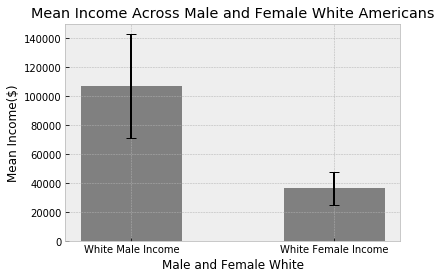

In [16]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
labels = ['White Male Income', 'White Female Income']
means = [whiteMaleMean, whiteFemaleMean]
CIs = [whiteMaleError, whiteFemaleError]
positions = [0, 1]

plt.bar(positions, means, color='grey', yerr=CIs, width=0.5, 
        align='center', ecolor='black', capsize=5)
plt.xlabel('Male and Female White')
plt.ylabel('Mean Income($)')
plt.title('Mean Income Across Male and Female White Americans')
plt.xticks(positions, labels)
plt.show()